<a href="https://colab.research.google.com/github/dimidagd/gists/blob/main/cars_classification_k_nn_dinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install opendatasets --upgrade --quiet

In [41]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
od.download(dataset_url)

Skipping, found downloaded files in "./stanford-car-dataset-by-classes-folder" (use force=True to force download)


In [42]:
import os

import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
DATA_DIR_TRAIN = './stanford-car-dataset-by-classes-folder/car_data/car_data/train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = './stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_classes = os.listdir(DATA_DIR_TEST)

train_classes[:5], test_classes[:5]
assert train_classes == test_classes
class_names = train_classes

In [43]:
from torchvision import transforms

class PadToSquare:
    def __call__(self, img):
        # Get the dimensions of the image
        width, height = img.size

        # Determine the size of the padding
        if width > height:
            padding = (0, (width - height) // 2, 0, (width - height + 1) // 2)  # Left, Top, Right, Bottom
        else:
            padding = ((height - width) // 2, 0, (height - width + 1) // 2, 0)  # Left, Top, Right, Bottom

        # Apply padding
        img = transforms.functional.pad(img, padding, fill=0)

        return img


preprocess = transforms.Compose([ PadToSquare(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [44]:
# Tie the class indices to their names

def find_classes(dir):
    test_classes = os.listdir(dir)
    test_classes.sort()
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)
def extract_class(Datasets):
  for vals in os.listdir(Datasets):
    print(vals)

train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = preprocess)
test_dataset = ImageFolder(DATA_DIR_TEST, transform = preprocess)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Label:  AM General Hummer SUV 2000 (0)


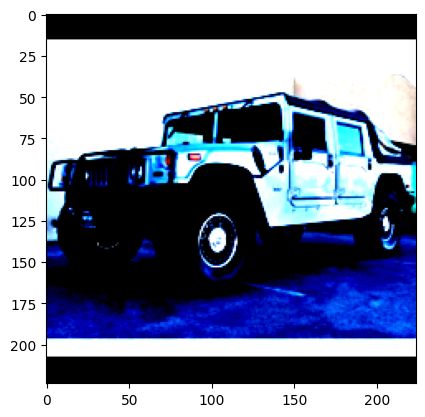

In [45]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*train_dataset[0])

In [46]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Load DINOv2 model
models= []
# DINOv2 with registers
models += [torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').to("cuda")]
#models += [torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')]
#models += [torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')]
#models += [torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')]

[model.eval() for model in models]

# Define the image transformation pipeline


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[DinoVisionTransformer(
   (patch_embed): PatchEmbed(
     (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
     (norm): Identity()
   )
   (blocks): ModuleList(
     (0-11): 12 x NestedTensorBlock(
       (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
       (attn): MemEffAttention(
         (qkv): Linear(in_features=384, out_features=1152, bias=True)
         (attn_drop): Dropout(p=0.0, inplace=False)
         (proj): Linear(in_features=384, out_features=384, bias=True)
         (proj_drop): Dropout(p=0.0, inplace=False)
       )
       (ls1): LayerScale()
       (drop_path1): Identity()
       (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
       (mlp): Mlp(
         (fc1): Linear(in_features=384, out_features=1536, bias=True)
         (act): GELU(approximate='none')
         (fc2): Linear(in_features=1536, out_features=384, bias=True)
         (drop): Dropout(p=0.0, inplace=False)
       )
       (ls2): LayerScale()
       (drop_path2): 

In [47]:
model = models[0]
from tqdm.notebook import tqdm
import numpy as np
def extract_features(dataloader):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            outputs = model(inputs.to("cuda"))
            all_features.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_features), np.hstack(all_labels)

# Extract features
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print(f"Train feature shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Test feature shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Train feature shape: (8144, 384), Train labels shape: (8144,)
Test feature shape: (8041, 384), Test labels shape: (8041,)


In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
# Train the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=1)

print("Training k-NN classifier")
knn.fit(train_features, train_labels)

# Evaluate the classifier
accuracy = knn.score(test_features, test_labels)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
print("Predicting on the test set")
y_pred = knn.predict(test_features)

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_names)
print(report)

Training k-NN classifier
Test accuracy: 75.95%
Predicting on the test set
                                                        precision    recall  f1-score   support

                       Lamborghini Reventon Coupe 2008       0.89      0.77      0.83        44
                      Hyundai Sonata Hybrid Sedan 2012       0.91      0.95      0.93        44
                              Plymouth Neon Coupe 1999       0.43      0.56      0.49        32
                    Chevrolet Malibu Hybrid Sedan 2010       0.57      0.60      0.58        43
                   Chevrolet Corvette Convertible 2012       0.74      0.76      0.75        42
                          Nissan NV Passenger Van 2012       0.57      0.60      0.59        40
                                 Jeep Patriot SUV 2012       0.81      0.64      0.71        39
                                Dodge Durango SUV 2007       0.51      0.42      0.46        45
                    Maybach Landaulet Convertible 2012       